![australian forest fire](https://www.commondreams.org/sites/default/files/styles/cd_large/public/headlines/aus.fires_.png?itok=sUktsMGH)

## Introduction

Forest fires have been a large problem throughout history but they have been particularly devastating in the past couple of years. Australia in particular has faced an unprecedented amount of forest fires over the past couple of months. When combatting forest fires, the ability to predict when, where, and how large the fire will be can be crucial information. Using machine learning techniques, we will try to predict the magnitude of forest fires using forest fire data of a national park in Portugal.

## Preprocessing and Exploratory Data Analysis

In order to explore and model our data, we must first import it.

In [1]:
### importing libraries ###

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [2]:
### importing data ###

df = pd.read_csv('data/forestfires.csv')

df.head()

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0


Now that we have our data imported, let's define what each of the features mean.
* X: where on the X-coordinate of the map the center of the fire is (map shown below)
* Y: where on the Y-coordinate of the map the center of the fire is (map shown below)
* month: the month of the fire
* day: the day of the fire (sunday-saturday)
* FFMC: fine fuel moisture code
* DMC: duff moisture code
* DC: drought code
* ISI: initial spread index (related to wind and FFMC)
* temp: temperature of weather (Celsius)
* RH: relative humidity (%)
* wind: wind speed (km/h)
* rain: rainfall (mm/m^2)
* area: total area burned (ha). Small fires were recorded to have 0 ha burnt but a fire still occurred.

We should note right away that ISI might have correlation with FFMC and wind but we will investigate further later.
![map of Portugal fire](https://i.gyazo.com/cf029585dbe4bcb9824834125844f423.png)

First let's look for any null values.

In [3]:
### null values ###

df.isna().sum()

X        0
Y        0
month    0
day      0
FFMC     0
DMC      0
DC       0
ISI      0
temp     0
RH       0
wind     0
rain     0
area     0
dtype: int64

The dataset does not have missing values. Now let's see if the values seem to be reasonable.

In [4]:
### overall data ###

print('The shape of the dataset is:', df.shape)

df.describe().transpose()

The shape of the dataset is: (517, 13)


,count,mean,std,min,25%,50%,75%,max
X,517.0,4.669246,2.313778,1.0,3.0,4.00,7.00,9.00
Y,517.0,4.299807,1.229900,2.0,4.0,4.00,5.00,9.00
FFMC,517.0,90.644681,5.520111,18.7,90.2,91.60,92.90,96.20
DMC,517.0,110.872340,64.046482,1.1,68.6,108.30,142.40,291.30
DC,517.0,547.940039,248.066192,7.9,437.7,664.20,713.90,860.60
ISI,517.0,9.021663,4.559477,0.0,6.5,8.40,10.80,56.10
temp,517.0,18.889168,5.806625,2.2,15.5,19.30,22.80,33.30
RH,517.0,44.288201,16.317469,15.0,33.0,42.00,53.00,100.00
wind,517.0,4.017602,1.791653,0.4,2.7,4.00,4.90,9.40
rain,517.0,0.021663,0.295959,0.0,0.0,0.00,0.00,6.40


We see that no feature seems to have ranges outside of the ordinary. For example, RH is in % so 100 should be the highest possible number whereas 0 should be the lowest possible. Now let's start some cleanup. First we will look at months.

Text(0.5, 1.0, 'Count plot of months')

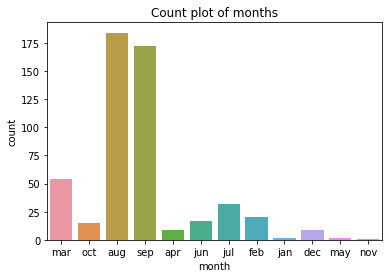

In [5]:
### exploring months ###

# visualizing months
sns.countplot(df['month'])
plt.title('Count plot of months')

We see that the data is largely skewed towards August and September, which are months in the summer of Portugal. Due to the size of our dataset (517 rows), it is unlikely that we will gain much information by encoding all 12 months with dummy variables... especially with such a large skew. Instead, we are going to separate them into Portugal's seasons of Spring, Summer, Autumn, and Winter. We will keep careful mind that the season has a good chance of being correlated with temperature and rain but we need to reduce the amount of features we have.

Text(0.5, 1.0, 'Count plot of seasons')

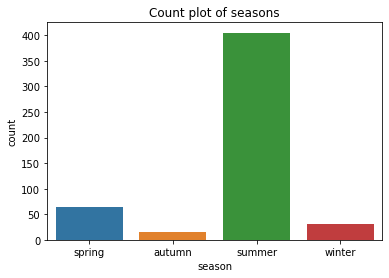

In [6]:
### months to seasons ###

# dictionary of months mapping to seasons
season_dict = {'dec' : 'winter', 'jan' : 'winter', 'feb' : 'winter',
              'mar' : 'spring', 'apr' : 'spring', 'may' : 'spring',
              'jun' : 'summer', 'jul' : 'summer', 'aug' : 'summer', 'sep' : 'summer',
              'oct' : 'autumn', 'nov' : 'autumn'}

# applying dictionary
df = df.replace({'month' : season_dict})

# renaming column
df = df.rename(columns = {'month' : 'season'})

# visualizing data
sns.countplot(df['season'])
plt.title('Count plot of seasons')

It is apparent that Summer has way too large of a skew. In order to combat this, we will conver the column into 'summer' or 'not summer'.

Text(0.5, 1.0, 'Count plot of summer vs other seasons')

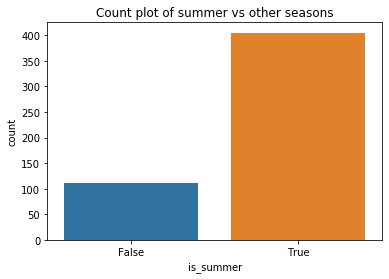

In [7]:
### converting season to summer or not summer ###

# converting to is summer
df['season'] = (df['season'] == 'summer')

# renaming column
df = df.rename(columns = {'season' : 'is_summer'})

# visualizing data
sns.countplot(df['is_summer'])
plt.title('Count plot of summer vs other seasons')

The distribution is still skewed but it is better than before. Now we can move onto days.

Text(0.5, 1.0, 'Count plot of days')

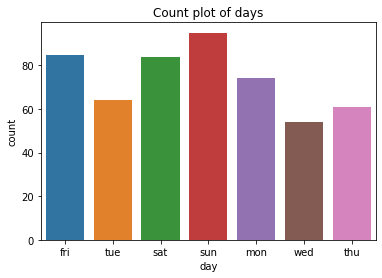

In [8]:
### exploring days ###

# visualizing days
sns.countplot(df['day'])
plt.title('Count plot of days')

The distribution for days seems pretty even. We will, instead of encoding 7 variables, separate these into weekend or not weekend. The reasoning behind this is that the amount of area burned in a fire is also related to how the fire fighters responded to the flame. During the weekend, the amount of firefighters or the response in general may be different compared to during the weekday. 

Text(0.5, 1.0, 'Count plot of weekend vs weekday')

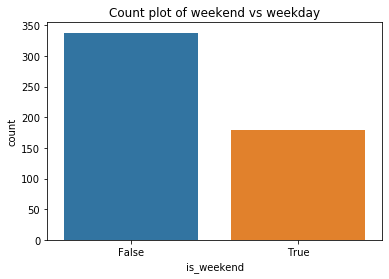

In [9]:
### turning days into is_weekend ###

# converting to is weekend
df['day'] = ((df['day'] == 'sun') | (df['day'] == 'sat'))

# renaming column
df = df.rename(columns = {'day' : 'is_weekend'})

# visualizing
sns.countplot(df['is_weekend'])
plt.title('Count plot of weekend vs weekday')

The skew is not too large so we are happy with this conversion. Now let's look at the distributions of each column to see if there is anything odd.

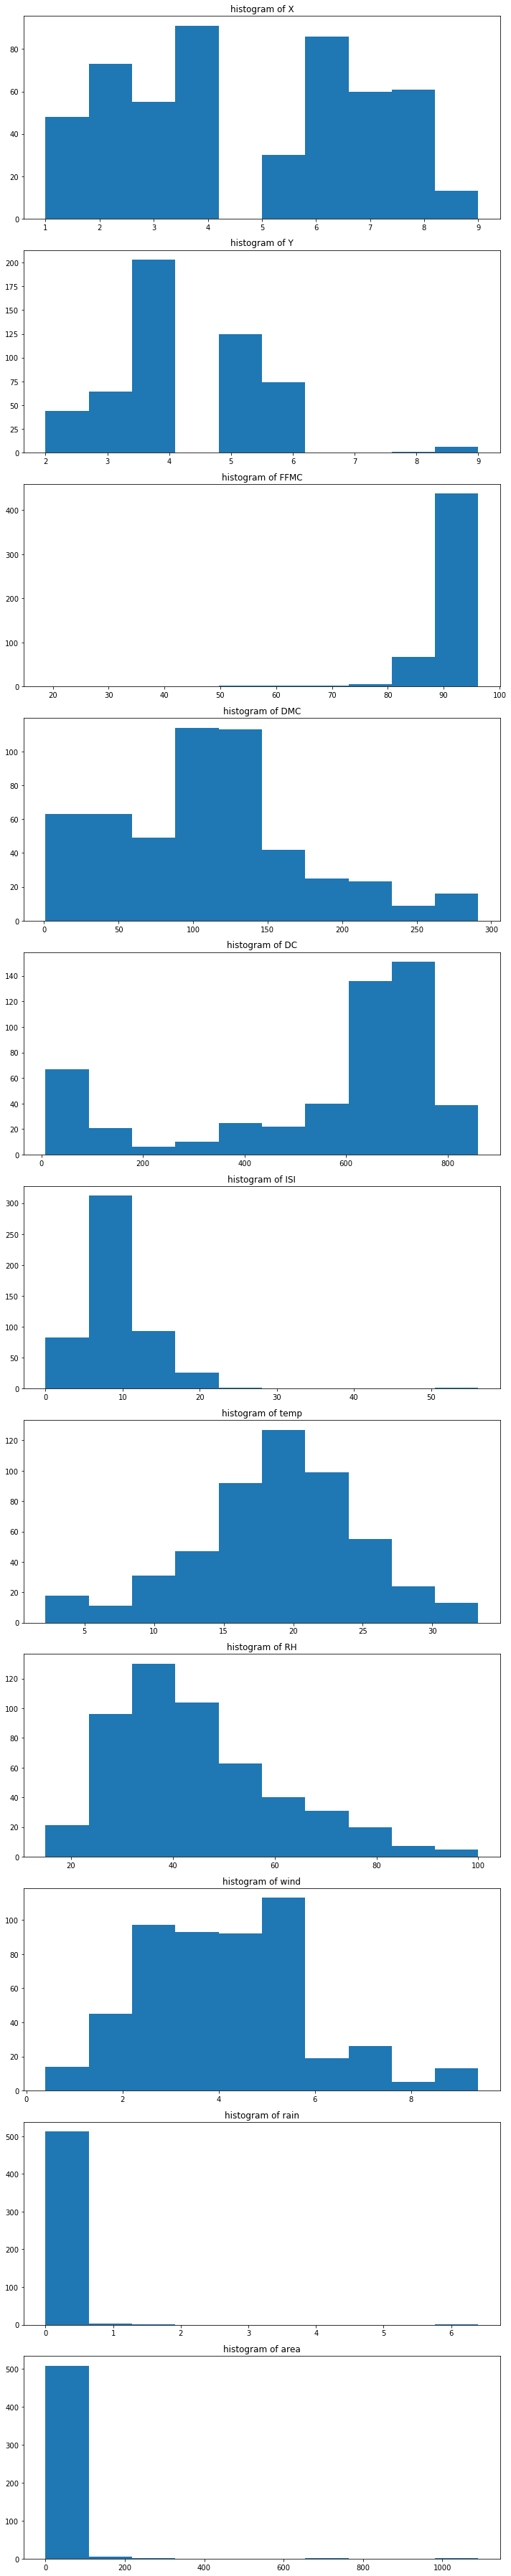

In [10]:
### visualizing distributions ###

# subplots
fig, ax = plt.subplots(11, figsize = (10,50))

# initial index
index = 0
unused_column = ['X', 'Y', 'FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind', 'rain', 'area']

# visualizing
for column in unused_column:
    if column != 'is_summer':
        ax[index].hist(df[column])
        ax[index].title.set_text('histogram of ' + column)
        index += 1

# making plots visible
plt.tight_layout()

We see that most of the distributions look relatively normally distributed. However, X and Y have no patterns for distribution which makes sense since we do not know the geography of the natural park. This means that we do not know where the trees are for fires so the distribution is not normal. We, however, can not do anything about this other than drop the features so we will keep them for now and see if they become problematic in the future. The distributions of rain and area are too skewed and have large outliers so we will scale it to even out the distribution.

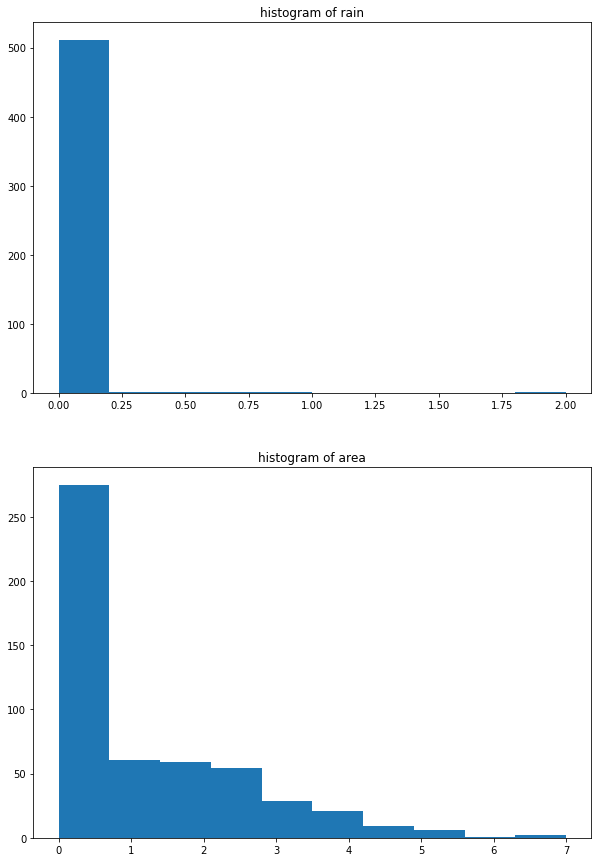

In [11]:
### scaling area and rain ###

# natural logarithm scaling (+1 to prevent errors at 0)
df.loc[:, ['rain', 'area']] = df.loc[:, ['rain', 'area']].apply(lambda x: np.log(x + 1), axis = 1)

# visualizing
fig, ax = plt.subplots(2, figsize = (10, 15))

ax[0].hist(df['rain'])
ax[0].title.set_text('histogram of rain')

ax[1].hist(df['area'])
ax[1].title.set_text('histogram of area')

The distribution for rain is not good but the distribution for area is highly improved. Now we scale the entire dataset. Note that we plan on testing a neural network on the dataset so we will scale the area as a preventative measure against an exploding gradient. First we will split the data into train and test splits so that we can scale the train set and then scale the test set based on the train set. Then we will scale everything.

In [12]:
### train test split ###

# separating features from target
# normally we use X and y but since X and Y are variables, we use the names features and targets to prevent potential conflicts
features = df.drop(['area'], axis = 1)
target = df['area'].values.reshape(-1, 1)

# splitting into train test set
features_train, features_test, target_train, target_test = train_test_split(features, target, 
                                                                            test_size = 0.5, random_state = 42)

In [13]:
### scaling data ###

# fitting scaler
sc_feature = StandardScaler()
sc_target = StandardScaler()

# transforming features
features_test = sc_feature.fit_transform(features_test)
features_train = sc_feature.transform(features_train)

# transforming target
target_test = sc_target.fit_transform(target_test)
target_train = sc_target.transform(target_train)

Finally, we can export these as csv files and start modelling.

In [14]:
### converting everything to dataframe for csv storage ###

# features
features_test = pd.DataFrame(features_test, columns = features.columns)
features_train = pd.DataFrame(features_train, columns = features.columns)

# target
target_test = pd.DataFrame(target_test, columns = ['area'])
target_train = pd.DataFrame(target_train, columns = ['area'])

# checking to see if everything is in order
features_test.head()

,X,Y,is_summer,is_weekend,FFMC,DMC,DC,ISI,temp,RH,wind,rain
0,0.598790,0.576522,-1.821172,1.418319,-1.139945,-1.305419,-1.748511,-1.149368,-1.234987,3.106552,0.400935,-0.119172
1,1.023686,0.576522,0.549097,-0.705060,1.072840,1.240626,0.527797,0.923229,0.433913,1.334447,0.400935,8.263105
2,1.448581,1.388040,0.549097,-0.705060,0.268190,1.671342,0.533514,-0.247405,1.065826,-0.865409,-1.357179,-0.119172
3,0.173895,-0.234995,0.549097,-0.705060,0.710747,-0.355849,0.613965,1.230280,0.190869,0.234519,0.400935,-0.119172
4,-1.100790,-0.234995,0.549097,-0.705060,0.750980,0.547157,0.600896,2.017099,1.665333,-0.804301,0.400935,-0.119172


In [15]:
### saving everything to csv ###

# features
features_test.to_csv('data/features_test.csv')
features_train.to_csv('data/features_train.csv')

# target
target_test.to_csv('data/target_test.csv')
target_train.to_csv('data/target_train.csv')

Now that we are done, we can take the preprocessed data and start modelling them.